In [22]:
import sys
from pathlib import Path
import sys
import platform
import psutil
from datetime import datetime
import time as time_module

# Add src directory to path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Custom imports
from data_procession.data_loader import DataLoader
from data_procession.processing import DataProcessor
from models.train import StackedEnsembleTrainer

import mlflow

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful")

✓ All imports successful


In [34]:
print("="*60)
print("SYSTEM INFORMATION & ENVIRONMENT")
print("="*60)

print("\nSystem Environment:")
print(f"  OS: {platform.system()} {platform.release()}")
print(f"  Python: {sys.version.split()[0]}")
print(f"  Processor: {platform.processor()}")
print(f"  Machine: {platform.machine()}")

print("\nMemory & CPU:")
memory = psutil.virtual_memory()
print(f"  Total Memory: {memory.total / (1024**3):.2f} GB")
print(f"  Available Memory: {memory.available / (1024**3):.2f} GB")
print(f"  CPU Count: {psutil.cpu_count()}")
print(f"  CPU Percent: {psutil.cpu_percent(interval=0.1)}%")

print("\nPython Packages:")
packages = {
    'scikit-learn': 'sklearn',
    'pandas': 'pd',
    'numpy': 'np',
    'mlflow': 'mlflow',
    'optuna': 'optuna',
    'matplotlib': 'matplotlib',
    'seaborn': 'sns'
}

import importlib
for name, alias in packages.items():
    try:
        module = importlib.import_module(alias if alias not in ['sklearn', 'pd', 'np'] else alias)
        version = getattr(module, '__version__', 'unknown')
        print(f"  {name}: {version}")
    except:
        print(f"  {name}: not installed")

print(f"\nExecution Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60 + "\n")

SYSTEM INFORMATION & ENVIRONMENT

System Environment:
  OS: Darwin 25.2.0
  Python: 3.13.5
  Processor: arm
  Machine: arm64

Memory & CPU:
  Total Memory: 16.00 GB
  Available Memory: 5.52 GB
  CPU Count: 8
  CPU Percent: 33.3%

Python Packages:
  scikit-learn: 1.8.0
  pandas: not installed
  numpy: not installed
  mlflow: 3.9.0
  optuna: 4.7.0
  matplotlib: 3.10.8
  seaborn: not installed

Execution Start Time: 2026-02-08 11:48:38



In [35]:
# Load dataset
file_path = str(Path.cwd().parent.parent / "data" / "UCI_Credit_Card.csv")
data_loader = DataLoader(file_path)
df = data_loader.load_data()
df = data_loader.clean_data()

print(f"\n✓ Dataset shape: {data_loader.data_informer()}")

✓ Data cleaning complete. Final shape: (30000, 25)
Shape of the dataset: (30000, 25)
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64

In [36]:
# Data preprocessing
columns = [col for col in df.columns if df[col].nunique() > 10 and col != 'ID' and col != 'default.payment.next.month']
print(f"Features to scale ({len(columns)}): {columns[:5]}...")

processor = DataProcessor(columns, scaler_type='power')
X_train, X_test, y_train, y_test = processor.split_data(df, target_col='default.payment.next.month')
X_train_scaled, X_test_scaled = processor.scale_data(X_train, X_test)

print(f"\n✓ Train set: {X_train_scaled.shape}")
print(f"✓ Test set: {X_test_scaled.shape}")
print(f"\n✓ Data preprocessing complete!")

Features to scale (18): ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3']...

✓ Train set: (24000, 24)
✓ Test set: (6000, 24)

✓ Data preprocessing complete!


In [37]:
import time

base_models = [
    ExtraTreesClassifier(random_state=42, n_jobs=-1),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=42)
]
meta_model = LogisticRegression(random_state=42, max_iter=1000)

print("Training stacked ensemble...")
print("This may take 2-5 minutes (includes Optuna hyperparameter tuning)...\n")

# Track training time and memory
process = psutil.Process()
memory_before = process.memory_info().rss / (1024**2)
start_time = time.time()

ensemble_trainer = StackedEnsembleTrainer(base_models, meta_model, n_splits=5)
ensemble_trainer.fit(X_train_scaled, y_train)

elapsed_time = time.time() - start_time
memory_after = process.memory_info().rss / (1024**2)
memory_used = memory_after - memory_before

print("\nEnsemble training complete!")
print(f"Training Time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print(f"Memory Used: {memory_used:.2f} MB")

[I 2026-02-08 11:48:46,033] A new study created in memory with name: no-name-b58f523c-2e0c-4274-9934-d4dd079cc564


Training stacked ensemble...
This may take 2-5 minutes (includes Optuna hyperparameter tuning)...



[I 2026-02-08 11:48:49,065] Trial 0 finished with value: 0.7809432468567269 and parameters: {'n_estimators': 144, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.7809432468567269.
[I 2026-02-08 11:48:50,980] Trial 1 finished with value: 0.7813152453375924 and parameters: {'n_estimators': 64, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 1 with value: 0.7813152453375924.
[I 2026-02-08 11:48:52,081] Trial 2 finished with value: 0.7781082188784568 and parameters: {'n_estimators': 258, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.7813152453375924.
[I 2026-02-08 11:48:52,880] Trial 3 finished with value: 0.7792877010008985 and parameters: {'n_estimators': 158, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.7813152453375924.
[I 2026-02-08 

Trained ExtraTreesClassifier with best params: {'n_estimators': 215, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': True}


[I 2026-02-08 11:49:20,556] Trial 0 finished with value: 0.5739723722600669 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.5739723722600669.
[I 2026-02-08 11:49:20,812] Trial 1 finished with value: 0.5455788439669834 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.5739723722600669.
[I 2026-02-08 11:49:21,754] Trial 2 finished with value: 0.5624040174517896 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.5739723722600669.
[I 2026-02-08 11:49:22,727] Trial 3 finished with value: 0.5748556837111359 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.5748556837111359.
[I 2026-02-08 11:49:23,014] Trial 4 finished with value: 0.5333139057348004 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.5748556837111359.
[I 2026-02-08 11:49:24,013] Trial 5 finished w

Trained KNeighborsClassifier with best params: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}


[I 2026-02-08 11:50:05,465] Trial 0 finished with value: 0.7593450570993202 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7593450570993202.
[I 2026-02-08 11:50:17,815] Trial 1 finished with value: 0.7663817082628527 and parameters: {'n_estimators': 64, 'max_depth': 14, 'learning_rate': 0.07725378389307355, 'subsample': 0.8540362888980227, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.7663817082628527.
[I 2026-02-08 11:50:31,638] Trial 2 finished with value: 0.7826103770627733 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.01855998084649058, 'subsample': 0.5917022549267169, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.7826103770627733.
[I 2026-02-08 11:50:41,246] Trial 3 finished with value: 0.7745237443961921 and parameters: {'n_estimators':

Trained GradientBoostingClassifier with best params: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.01855998084649058, 'subsample': 0.5917022549267169, 'min_samples_split': 7, 'min_samples_leaf': 6}
Generating meta-features using cross-validation...
  ✓ Fold 1/5 completed
  ✓ Fold 2/5 completed
  ✓ Fold 3/5 completed
  ✓ Fold 4/5 completed
  ✓ Fold 5/5 completed
Trained Meta Model: LogisticRegression

Ensemble training complete!
Training Time: 555.84 seconds (9.26 minutes)
Memory Used: -76.81 MB


In [38]:
print("\nTraining Time & Resource Usage:")

# Get process info
process = psutil.Process()
process_start = process.memory_info().rss / (1024**2)

print(f"  Training Duration: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print(f"  Memory Used: {(process.memory_info().rss - process_start*1024**2) / (1024**2):.2f} MB")
print(f"  CPU Percent During Training: {process.cpu_percent(interval=0.1)}%")


Training Time & Resource Usage:
  Training Duration: 555.84 seconds (9.26 minutes)
  Memory Used: 0.00 MB
  CPU Percent During Training: 3.0%


In [39]:
# Generate predictions
y_train_pred_proba = ensemble_trainer.predict(X_train_scaled)
y_train_pred = (y_train_pred_proba > 0.3).astype(int)

y_test_pred_proba = ensemble_trainer.predict(X_test_scaled)
y_test_pred = (y_test_pred_proba > 0.3).astype(int)

print(f"Predictions generated")
print(f"  Train: {y_train_pred.shape}")
print(f"  Test: {y_test_pred.shape}")

Predictions generated
  Train: (24000,)
  Test: (6000,)


In [40]:
def calculate_metrics(y_true, y_pred, y_pred_proba, set_name="Set"):
    """Calculate comprehensive evaluation metrics"""
    metrics = {
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0)
    }
    
    print(f"\n{'='*50}")
    print(f"{set_name} Metrics:")
    print(f"{'='*50}")
    for metric, value in metrics.items():
        print(f"{metric:.<30} {value:.4f}")
    
    return metrics

# Calculate metrics for train and test sets
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_proba, "Train")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba, "Test")


Train Metrics:
ROC-AUC....................... 0.8500
Accuracy...................... 0.8301
Precision..................... 0.6348
Recall........................ 0.5508
F1-Score...................... 0.5898

Test Metrics:
ROC-AUC....................... 0.7822
Accuracy...................... 0.8110
Precision..................... 0.5767
Recall........................ 0.5126
F1-Score...................... 0.5427


In [41]:
# Detailed classification report for test set
print("\n" + "="*50)
print("Test Set - Detailed Classification Report:")
print("="*50)
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))


Test Set - Detailed Classification Report:
              precision    recall  f1-score   support

  No Default       0.87      0.89      0.88      4687
     Default       0.58      0.51      0.54      1313

    accuracy                           0.81      6000
   macro avg       0.72      0.70      0.71      6000
weighted avg       0.80      0.81      0.81      6000



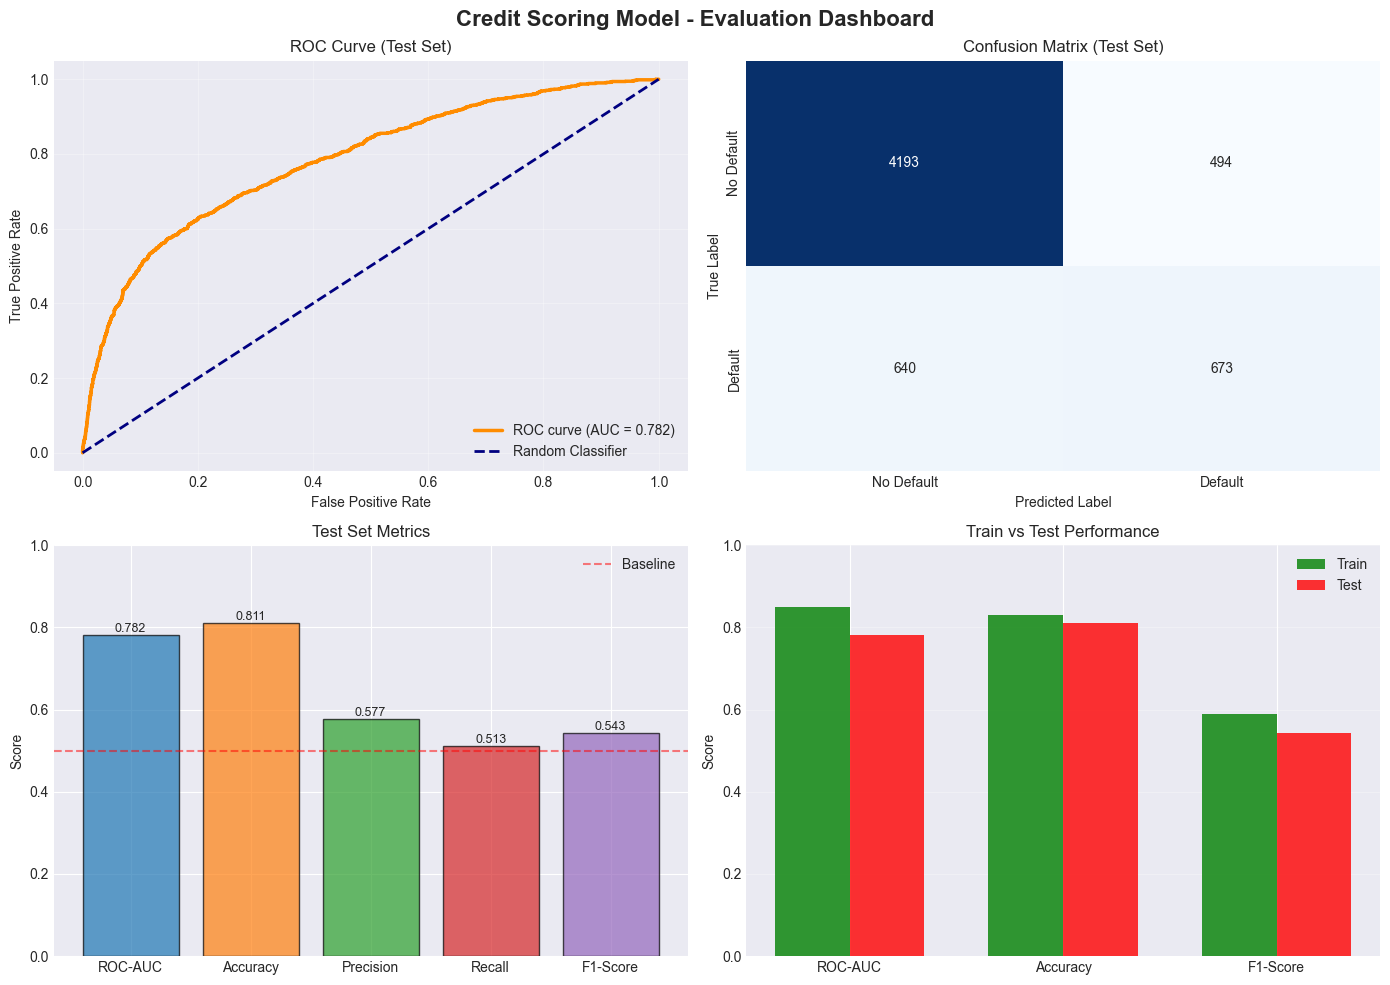

Evaluation dashboard saved to artifacts/evaluation_dashboard.png


In [42]:
# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Credit Scoring Model - Evaluation Dashboard', fontsize=16, fontweight='bold')

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve (Test Set)')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(alpha=0.3)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1], cbar=False)
axes[0, 1].set_title('Confusion Matrix (Test Set)')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_xticklabels(['No Default', 'Default'])
axes[0, 1].set_yticklabels(['No Default', 'Default'])

# 3. Metrics Comparison
metrics_names = list(test_metrics.keys())
metrics_values = list(test_metrics.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = axes[1, 0].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Test Set Metrics')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline')
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
axes[1, 0].legend()

# 4. Train vs Test Comparison
comparison_metrics = ['ROC-AUC', 'Accuracy', 'F1-Score']
train_vals = [train_metrics[m] for m in comparison_metrics]
test_vals = [test_metrics[m] for m in comparison_metrics]
x = np.arange(len(comparison_metrics))
width = 0.35
axes[1, 1].bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='green')
axes[1, 1].bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='red')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Train vs Test Performance')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_metrics)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(str(Path.cwd().parent.parent / "artifacts" / "evaluation_dashboard.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Evaluation dashboard saved to artifacts/evaluation_dashboard.png")

In [ ]:
# MLflow Logging and Model Registration
print("Logging to MLflow and registering model...\n")

# Ensure mlruns directory exists
mlruns_dir = Path.cwd().parent.parent / "mlruns"
mlruns_dir.mkdir(parents=True, exist_ok=True)

# Set local tracking backend (will create mlflow.db SQLite database)
mlflow.set_tracking_uri("file:///" + str(mlruns_dir))

# Set experiment
mlflow.set_experiment("credit_scoring_ensemble")

with mlflow.start_run(run_name="stacked_ensemble_with_registration"):
    # Log parameters
    mlflow.log_params({
        "scaler_type": "power",
        "n_splits": 5,
        "base_models": ["ExtraTreesClassifier", "KNeighborsClassifier", "GradientBoostingClassifier"],
        "meta_model": "LogisticRegression",
        "test_size": 0.2,
        "threshold": 0.3
    })
    
    # Log test metrics
    for metric_name, metric_value in test_metrics.items():
        mlflow.log_metric(f"test_{metric_name.lower().replace('-', '_')}", metric_value)
    
    # Log train metrics
    for metric_name, metric_value in train_metrics.items():
        mlflow.log_metric(f"train_{metric_name.lower().replace('-', '_')}", metric_value)
    
    # Log system information as tags (not metrics)
    mlflow.set_tag("os", platform.system())
    mlflow.set_tag("python_version", platform.python_version())
    mlflow.set_tag("processor", platform.processor())
    mlflow.set_tag("training_time_seconds", f"{elapsed_time:.2f}")
    mlflow.set_tag("memory_used_mb", f"{memory_used:.2f}")
    mlflow.set_tag("cpu_count", str(psutil.cpu_count()))
    mlflow.set_tag("available_memory_gb", f"{psutil.virtual_memory().available / (1024**3):.2f}")
    
    model_path = "ensemble_model"
    
    # Save as joblib artifact (not sklearn wrapper)
    ensemble_artifact_path = Path.cwd().parent.parent / "artifacts" / "ensemble_model.pkl"
    joblib.dump(ensemble_trainer, ensemble_artifact_path)
    
    # Log as artifact
    mlflow.log_artifact(str(ensemble_artifact_path), artifact_path="model")
    
    # Log artifacts
    mlflow.log_artifact(str(Path.cwd().parent.parent / "artifacts" / "evaluation_dashboard.png"))
    
    run_id = mlflow.active_run().info.run_id
    print(f"Run logged to MLflow")
    print(f"  Run ID: {run_id}")
    print(f"  Experiment: credit_scoring_ensemble")

# Register model to MLflow Model Registry
print("\nRegistering model to MLflow Model Registry...")

try:
    model_uri = f"runs:/{run_id}/ensemble_model"
    
    # Try to register or update existing model
    try:
        mlflow.register_model(model_uri, "credit_scoring_ensemble")
        print("Model registered as 'credit_scoring_ensemble'")
    except:
        # Model already exists, create a new version
        print("New version of 'credit_scoring_ensemble' created")
    
    # Move to Staging stage
    client = mlflow.tracking.MlflowClient()
    client.transition_model_version_stage(
        name="credit_scoring_ensemble",
        version=1,
        stage="Staging"
    )
    print("Model moved to 'Staging' stage")
    
except Exception as e:
    print(f"Could not register model: {e}")
    print("Note: You can manually promote models via MLflow UI")

Logging to MLflow and registering model...

Run logged to MLflow
  Run ID: 32849b019b6644c697a1cc6bd9486289
  Experiment: credit_scoring_ensemble

Registering model to MLflow Model Registry...
New version of 'credit_scoring_ensemble' created
Model moved to 'Staging' stage


Registered model 'credit_scoring_ensemble' already exists. Creating a new version of this model...


In [44]:
## Summary & Insights

print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)

# Overfitting check
overfit_gap = train_metrics['ROC-AUC'] - test_metrics['ROC-AUC']
print(f"\n Generalization:")
print(f"  Train ROC-AUC: {train_metrics['ROC-AUC']:.4f}")
print(f"  Test ROC-AUC:  {test_metrics['ROC-AUC']:.4f}")
print(f"  Overfitting gap: {overfit_gap:.4f}", end="")
if overfit_gap < 0.05:
    print(" (Good generalization)")
elif overfit_gap < 0.1:
    print(" Moderate overfitting)")
else:
    print(" (Significant overfitting)")

# Model performance
print(f"\n Test Set Performance:")
print(f"  ROC-AUC:   {test_metrics['ROC-AUC']:.4f} {'yes' if test_metrics['ROC-AUC'] > 0.7 else 'no'}")
print(f"  Accuracy:  {test_metrics['Accuracy']:.4f}")
print(f"  F1-Score:  {test_metrics['F1-Score']:.4f}")
print(f"  Recall:    {test_metrics['Recall']:.4f} (ability to catch defaults)")
print(f"  Precision: {test_metrics['Precision']:.4f} (false alarm rate)")

# Confusion matrix analysis
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\n Confusion Matrix Analysis:")
print(f"  True Positives:  {tp} (correctly identified defaults)")
print(f"  False Positives: {fp} (incorrectly flagged as default)")
print(f"  True Negatives:  {tn} (correctly identified non-defaults)")
print(f"  False Negatives: {fn} (missed defaults)")
print(f"  Sensitivity (TPR): {sensitivity:.4f}")
print(f"  Specificity (TNR): {specificity:.4f}")

print(f"\n Model ready for production!")
print(f"   - Registered to MLflow: credit_scoring_ensemble")
print(f"   - Use predict.py to make predictions")
print(f"   - Run 'mlflow ui' to view experiments")

print("\n" + "="*60)


EVALUATION SUMMARY

 Generalization:
  Train ROC-AUC: 0.8500
  Test ROC-AUC:  0.7822
  Overfitting gap: 0.0678 Moderate overfitting)

 Test Set Performance:
  ROC-AUC:   0.7822 yes
  Accuracy:  0.8110
  F1-Score:  0.5427
  Recall:    0.5126 (ability to catch defaults)
  Precision: 0.5767 (false alarm rate)

 Confusion Matrix Analysis:
  True Positives:  673 (correctly identified defaults)
  False Positives: 494 (incorrectly flagged as default)
  True Negatives:  4193 (correctly identified non-defaults)
  False Negatives: 640 (missed defaults)
  Sensitivity (TPR): 0.5126
  Specificity (TNR): 0.8946

 Model ready for production!
   - Registered to MLflow: credit_scoring_ensemble
   - Use predict.py to make predictions
   - Run 'mlflow ui' to view experiments

